## 起始設定

In [1]:
import talib
import numpy as np
import pandas as pd
from finlab.data import Data

folder = '/Volumes/Macintosh HD/history'

stock_id = '2412'

data = Data(folder)

## 取得預設持有報酬率

In [2]:
open_adj = data.get_adj('開盤價')

profit1 =  open_adj.shift(-2) / open_adj.shift(-1)
profit5 =  open_adj.shift(-6) / open_adj.shift(-1)
profit10 = open_adj.shift(-11) / open_adj.shift(-1)
profit60 = open_adj.shift(-61) / open_adj.shift(-1)

profit1 = profit1.unstack()
profit5 = profit5.unstack()
profit10 = profit10.unstack()
profit60 = profit60.unstack()

## 分析candlestick

In [25]:
from talib import abstract

strategies = {}
signals = {}

candlesticks = [fname for fname in dir(abstract) if fname[:3] == 'CDL']

for index, fname in enumerate(candlesticks, 1):
    print(f'{index}/{len(candlesticks)}: {fname} is running')

    df = data.talib(fname)
    df = df.unstack()
    df = df[df!= 0]

    stock_series = df.dropna(axis=0)

    if stock_series.empty:
        continue

    pos = stock_series > 0
    neg = stock_series < 0
    
    # profit 用cumprod 算出總報酬率
    # 用mean 可算出該蠟燭形態 的報酬率都落在什麼位置
    # mean 大於 1 至少可說這報酬率是正值 會賺錢
    strategies[fname] = {
        "positive_profit_1": profit1.loc[pos.index].unstack(level=0).mean(),
        "positive_profit_5": profit5.loc[pos.index].unstack(level=0).mean(),
        "positive_profit_10": profit10.loc[pos.index].unstack(level=0).mean(),
        "negative_profit_1": profit1.loc[neg.index].unstack(level=0).mean(),
        "negative_profit_5": profit5.loc[neg.index].unstack(level=0).mean(),
        "negative_profit_10": profit10.loc[neg.index].unstack(level=0).mean(),
    }
    
    signals[fname] = {
        "positive": stock_series[pos],
        "negative": stock_series[neg]
    }

1/61: CDL2CROWS is running
2/61: CDL3BLACKCROWS is running
3/61: CDL3INSIDE is running
4/61: CDL3LINESTRIKE is running
5/61: CDL3OUTSIDE is running
6/61: CDL3STARSINSOUTH is running
7/61: CDL3WHITESOLDIERS is running
8/61: CDLABANDONEDBABY is running
9/61: CDLADVANCEBLOCK is running
10/61: CDLBELTHOLD is running
11/61: CDLBREAKAWAY is running
12/61: CDLCLOSINGMARUBOZU is running
13/61: CDLCONCEALBABYSWALL is running
14/61: CDLCOUNTERATTACK is running
15/61: CDLDARKCLOUDCOVER is running
16/61: CDLDOJI is running
17/61: CDLDOJISTAR is running
18/61: CDLDRAGONFLYDOJI is running
19/61: CDLENGULFING is running
20/61: CDLEVENINGDOJISTAR is running
21/61: CDLEVENINGSTAR is running
22/61: CDLGAPSIDESIDEWHITE is running
23/61: CDLGRAVESTONEDOJI is running
24/61: CDLHAMMER is running
25/61: CDLHANGINGMAN is running
26/61: CDLHARAMI is running
27/61: CDLHARAMICROSS is running
28/61: CDLHIGHWAVE is running
29/61: CDLHIKKAKE is running
30/61: CDLHIKKAKEMOD is running
31/61: CDLHOMINGPIGEON is runni

In [32]:
for name, signal in signals.items():
    print(name)
    print('positive: ' + str(len(signal['positive'])))
    print('negative: ' + str(len(signal['negative'])))

CDL2CROWS
positive: 0
negative: 2731
CDL3BLACKCROWS
positive: 0
negative: 2213
CDL3INSIDE
positive: 25017
negative: 11786
CDL3LINESTRIKE
positive: 702
negative: 673
CDL3OUTSIDE
positive: 21470
negative: 70241
CDL3STARSINSOUTH
positive: 16
negative: 0
CDL3WHITESOLDIERS
positive: 2557
negative: 0
CDLABANDONEDBABY
positive: 169
negative: 175
CDLADVANCEBLOCK
positive: 0
negative: 8103
CDLBELTHOLD
positive: 464464
negative: 583064
CDLBREAKAWAY
positive: 91
negative: 134
CDLCLOSINGMARUBOZU
positive: 378972
negative: 487471
CDLCONCEALBABYSWALL
positive: 8
negative: 0
CDLCOUNTERATTACK
positive: 6255
negative: 8407
CDLDARKCLOUDCOVER
positive: 0
negative: 16335
CDLDOJI
positive: 910802
negative: 0
CDLDOJISTAR
positive: 38145
negative: 41512
CDLDRAGONFLYDOJI
positive: 137883
negative: 0
CDLENGULFING
positive: 54282
negative: 151201
CDLEVENINGDOJISTAR
positive: 0
negative: 4224
CDLEVENINGSTAR
positive: 0
negative: 12709
CDLGAPSIDESIDEWHITE
positive: 16743
negative: 16328
CDLGRAVESTONEDOJI
positive

{'positive': Series([], dtype: int32),
 'negative':       date      
 0050  2011-01-04   -100
       2018-11-30   -100
 0051  2008-01-11   -100
       2012-04-27   -100
       2016-06-03   -100
                    ... 
 9955  2016-08-11   -100
 9958  2009-04-23   -100
       2009-06-26   -100
       2012-12-28   -100
 9962  2017-02-17   -100
 Length: 2731, dtype: int32}

## 將所有報酬率統整到dataframe
用 Multiple Index 的方式 將 candle stick name & stock id 作為 indies 
並且用各種profit當作 column 組合出一個dataframe

In [8]:
df_ = []
candlesitck_names = []
for candlesitck in strategies:
    df = pd.DataFrame(strategies[candlesitck])
    candlesitck_names.append(candlesitck)
    df_.append(df)

df_total = pd.concat(df_, keys=candlesitck_names, axis=0)

# 將 mutiple index 依照類型命名
df_total.index.names = ['candlestick', df_total.index.names[1]]
df_total

# df_total.plot()

positive_profit_1  positive_profit_5  \
candlestick                                                      
CDL2CROWS           0050           0.997219           0.977666   
                    0051           1.003568           0.997190   
                    0052           0.981431           0.970361   
                    0053           0.997887           0.996461   
                    0054           0.999762           0.998392   
...                                     ...                ...   
CDLXSIDEGAP3METHODS 9950           0.988552           0.978522   
                    9951           1.042254           1.056338   
                    9955           0.960280           0.883178   
                    9958           0.951263           1.045020   
                    9960           0.963220           0.949647   

                          positive_profit_10  negative_profit_1  \
candlestick                                                       
CDL2CROWS           0050            0.985989           0.997219   
                    0051            0.963726           1.003568   
                    0052            0.971178           0.981431   
                    0053            1.004212           0.997887   
                    0054            1.013641           0.999762   
...                                      ...                ...   
CDLXSIDEGAP3METHODS 9950            0.967826           0.988552   
                    9951            1.084507           1.042254   
                    9955            0.981308           0.960280   
                    9958            1.049189           0.951263   
                    9960            0.853866           0.963220   

                          negative_profit_5  negative_profit_10  
candlestick                                                      
CDL2CROWS           0050           0.977666            0.985989  
                    0051           0.997190            0.963726  
                    0052           0.970361            0.971178  
                    0053           0.996461            1.004212  
                    0054           0.998392            1.013641  
...                                     ...                 ...  
CDLXSIDEGAP3METHODS 9950           0.978522            0.967826  
                    9951           1.056338            1.084507  
                    9955           0.883178            0.981308  
                    9958           1.045020            1.049189  
                    9960           0.949647            0.853866  

[91494 rows x 6 columns]

## 取得所有策略的平均報酬率

In [20]:
profit_series = df_total.mean(axis=1)

# 取得正負報酬率統計
pos_profit = profit_series[profit_series > 1].mean(level=0)
neg_profit = profit_series[profit_series < 1].mean(level=0)

# 按照報酬率排序
neg_profit = neg_profit.sort_values(ascending=True)
pos_profit = pos_profit.sort_values(ascending=False)

candlestick
CDLMATHOLD             1.046745
CDLKICKING             1.046600
CDLKICKINGBYLENGTH     1.046600
CDLRISEFALL3METHODS    1.040570
CDLBREAKAWAY           1.038991
                         ...   
CDLDOJI                1.004123
CDLLONGLEGGEDDOJI      1.004079
CDLLONGLINE            1.003874
CDLBELTHOLD            1.003792
CDLCLOSINGMARUBOZU     1.003639
Length: 61, dtype: float64

In [24]:
# 取出要計算策略的candlestick
pos_candlestick = pos_profit.head(10).index.to_list()

neg_candlestick = neg_profit.head(10).index.to_list()

['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE']

In [ ]:
# 計算持有時間

hold = pd.DataFrame(np.nan, index=, columns=)

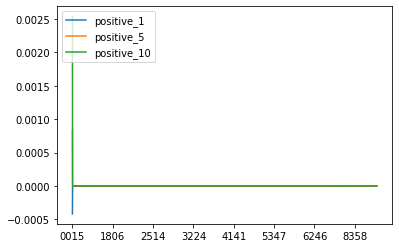

In [7]:
df_profit = pd.DataFrame(strategies['CDLBELTHOLD'])
for column in df_profit.columns:
    if not 'positive_profit' in column:
        continue
    ret = df_profit.shift(-1)[column] - df_profit[column]
    cret_total = ret.cumprod()
    ax1 = cret_total.plot(label=column.replace('_profit_','_'))
    h1, l1 = ax1.           get_legend_handles_labels()

import matplotlib.pyplot as plt

plt.legend(h1, l1, loc=2)

plt.show()

In [ ]:
strategies_ = {}
fname = 'CDL3INSIDE'
df = data.talib(fname)
df = df.unstack()
df = df[df!= 0]

stock_series = df.dropna(axis=0)

pos = stock_series > 0
neg = stock_series < 0

# profit 用cumprod 算出總報酬率
# 用mean 可算出該蠟燭形態 的報酬率都落在什麼位置
# mean 大於 1 至少可說這報酬率是正值 會賺錢
strategies_[fname] = {
    "positive_profit_1": profit1.loc[pos.index].unstack(level=0).mean(),
    "positive_profit_5": profit5.loc[pos.index].unstack(level=0).mean(),
    "positive_profit_10": profit10.loc[pos.index].unstack(level=0).mean(),
    "negative_profit_1": profit1.loc[neg.index].unstack(level=0).mean(),
    "negative_profit_5": profit5.loc[neg.index].unstack(level=0).mean(),
    "negative_profit_10": profit10.loc[neg.index].unstack(level=0).mean(),
}

In [ ]:
open_adj = data.get_adj('開盤價')
ret = open_adj.shift(-1)[stock_id] - open_adj[stock_id]

cret_total = ret.cumsum()

cret_total.plot()

In [ ]:
profit10.loc[pos.index]['0015']

In [ ]:
p = profit10.loc[pos.index]['0015'].cumprod()

p.plot()

In [ ]:
profit10.loc[pos.index]['0015'].mean()

In [ ]:
profit5.loc[pos.index].unstack(level=0).mean()

In [ ]:
df1 = pd.DataFrame(strategies['CDLSHOOTINGSTAR'])
df1.index.name = 'stock_id'
df2 = pd.DataFrame(strategies['CDL3INSIDE'])
df2.index.name = 'stock_id'

df3 = pd.DataFrame(strategies['CDL3OUTSIDE'])
df3.index.name = 'stock_id'

df4 = pd.DataFrame(strategies['CDLTAKURI'])
df4.index.name = 'stock_id'

dfx = [df1, df2, df3, df4]

dfy = pd.concat(dfx,keys= ['CDLSHOOTINGSTAR','CDL3INSIDE','CDL3OUTSIDE','CDLTAKURI'],axis=0)

dfy.index.names = ['candlestick',dfy.index.names[1]]

dfy

In [ ]:
df_ = []
candlesitck_names = []
for candlesitck in strategies:
    df = pd.DataFrame(strategies[candlesitck])
    candlesitck_names.append(candlesitck)
    df_.append(df)

dfy = pd.concat(df_, keys=candlesitck_names, axis=0)

dfy.index.names = ['candlestick', dfy.index.names[1]]
dfy